In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import polars as pl

In [3]:
test_path = os.path.join(os.getenv("HOME"), "higgs", "test.parquet")
train_path = os.path.join(os.getenv("HOME"), "higgs", "train.parquet")

In [4]:
os.path.exists(test_path), os.path.exists(train_path)

(True, True)

In [5]:
train_df, test_df = pl.read_parquet(train_path), pl.read_parquet(test_path)

In [6]:
data_col_count = 28
data_cols = [str(col + 1) for col in range(data_col_count)]

In [7]:
import torch
torch.manual_seed(6996)

In [8]:
target_count = 2

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(
        in_features = data_col_count,
        out_features = 128,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = 128,
        out_features = data_col_count,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count,
        out_features = data_col_count // 2,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count // 2,
        out_features = data_col_count // 4,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count // 4,
        out_features = target_count,
    ),
    torch.nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=28, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=28, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=28, out_features=14, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=14, out_features=7, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=7, out_features=2, bias=True)
  (9): Sigmoid()
)

In [10]:
class HiggsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data_s = df["label"]
        self.label_df = df[data_cols]
    def __len__(self) -> int:
        return len(self.data_s)
    def __getitem__(self, index):
        y = self.data_s.item(index)
        x = self.label_df.row(index)
        xt = torch.asarray(x).to(torch.float32)
        yt = torch.zeros(size = (target_count,), dtype = torch.float32)
        yt.index_fill_(dim = 0, index = torch.asarray(y).to(torch.int64), value = 1.0)
        return (xt, yt)

In [11]:
train_ds = HiggsDataset(df = train_df)
train_ds[16]

(tensor([ 1.4842,  1.6995, -1.0595,  2.7002, -1.0560,  2.4095,  0.4575,  0.3450,
         -1.0000,  1.4149,  1.1142, -1.4489, -1.0000,  1.0130, -2.0570,  1.1310,
         -1.0000,  0.9055,  2.1824,  1.0431, -1.0000,  1.6536,  0.9936,  0.9833,
          0.7414,  0.1634,  0.5923,  0.7451]),
 tensor([0., 1.]))

In [12]:
gen = torch.Generator(device = "cpu")
gen.manual_seed(6969)
train_dl = torch.utils.data.DataLoader(
    dataset = train_ds, 
    batch_size = 25_000, 
    shuffle = True, 
    pin_memory = True, 
    num_workers = 4, 
    generator = gen,
)

In [13]:
from tqdm import tqdm

In [14]:
import rootutils
path = rootutils.find_root(search_from = os.getcwd(), indicator = ".project-root")
rootutils.set_root(path = path, project_root_env_var = True, dotenv = True, pythonpath = True, cwd = True,)

In [15]:
from fourier.roc_auc_loss import RocAuc
from fourier.integration import integrate
from fourier.compute_fourier import compute_fourier
from fourier.evaluate_fourier import evaluate_fourier
from fourier.custom_typing import DeviceLike, FPTensor
from fourier.fourier import normalize_by_samples, SinCos, DEFAULT_FACTOR

In [16]:
rocauc_loss = RocAuc(n_harmonics = 128, n_points = 4_096, statistic = "flatten").cuda()
rocauc_loss = torch.compiler.disable(fn = rocauc_loss, recursive = True)

In [17]:
bce_loss = torch.nn.BCELoss().cuda()

In [18]:
sample_x, sample_y = next(iter(train_dl))
sample_x, sample_y = sample_x.cuda(), sample_y.cuda()

In [19]:
# Warm up
rocauc_loss(sample_x, sample_y)

tensor(0.5022, device='cuda:0')

In [20]:
fourier_values, bce_values = [], []

model_train = model.cuda().train().cuda()
optimizer = torch.optim.Adam(model_train.parameters(), lr = 1e-4)
for i in tqdm(range(5)):
    for j, (x, y) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()
        result = model_train.forward(x.cuda())
        y_float = y.cuda()
        y_bool = y_float.to(torch.bool)
        bce_loss_value = bce_loss(result, y_float)
        rocauc_loss_value = rocauc_loss(result, y_bool)
        loss_value = 1.0 - 1.0 * rocauc_loss_value + 0.5 * bce_loss_value
        if j % 10 == 0:
            fourier_values.append(rocauc_loss_value.detach().cpu().item())
            bce_values.append(bce_loss_value.detach().cpu().item())
            print("\tFourier:", fourier_values[-1])
            print("\tBCE:", bce_values[-1])
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
model = model_train.cpu().eval().cpu()

  0%|                                                                                           | 0/400 [00:00<?, ?it/s]

	Fourier: 0.5297988653182983
	BCE: 0.6948938965797424



  3%|██▎                                                                               | 11/400 [00:04<01:51,  3.49it/s]

	Fourier: 0.5299351811408997
	BCE: 0.6951407790184021



  5%|████▎                                                                             | 21/400 [00:07<02:02,  3.09it/s]

	Fourier: 0.5370885133743286
	BCE: 0.6942728161811829



  8%|██████▎                                                                           | 31/400 [00:10<01:48,  3.39it/s]

	Fourier: 0.5400837659835815
	BCE: 0.6942155957221985



 10%|████████▍                                                                         | 41/400 [00:13<01:37,  3.69it/s]

	Fourier: 0.5350322127342224
	BCE: 0.6951676607131958



 12%|██████████▎                                                                       | 50/400 [00:15<01:35,  3.65it/s]

	Fourier: 0.5445369482040405
	BCE: 0.6940962076187134



 15%|████████████▌                                                                     | 61/400 [00:18<01:27,  3.90it/s]

	Fourier: 0.5424432754516602
	BCE: 0.6947079300880432



 18%|██████████████▌                                                                   | 71/400 [00:21<01:26,  3.80it/s]

	Fourier: 0.5460011959075928
	BCE: 0.6944491863250732



 20%|████████████████▌                                                                 | 81/400 [00:23<01:25,  3.74it/s]

	Fourier: 0.5542775392532349
	BCE: 0.6937581300735474



 23%|██████████████████▋                                                               | 91/400 [00:26<01:21,  3.79it/s]

	Fourier: 0.556632399559021
	BCE: 0.6940397620201111



 25%|████████████████████▍                                                            | 101/400 [00:28<01:19,  3.74it/s]

	Fourier: 0.5700370669364929
	BCE: 0.6929858922958374



 28%|██████████████████████▍                                                          | 111/400 [00:31<01:14,  3.86it/s]

	Fourier: 0.5707599520683289
	BCE: 0.6932409405708313



 30%|████████████████████████▌                                                        | 121/400 [00:34<01:14,  3.75it/s]

	Fourier: 0.5753084421157837
	BCE: 0.6928471922874451



 33%|██████████████████████████▌                                                      | 131/400 [00:36<01:16,  3.53it/s]

	Fourier: 0.5827902555465698
	BCE: 0.6925755143165588



 35%|████████████████████████████▌                                                    | 141/400 [00:39<01:11,  3.64it/s]

	Fourier: 0.5854699015617371
	BCE: 0.6926491856575012



 38%|██████████████████████████████▍                                                  | 150/400 [00:42<01:12,  3.47it/s]

	Fourier: 0.5936385989189148
	BCE: 0.6919584274291992



 40%|████████████████████████████████▌                                                | 161/400 [00:45<01:09,  3.43it/s]

	Fourier: 0.5972232818603516
	BCE: 0.6916406154632568



 43%|██████████████████████████████████▋                                              | 171/400 [00:48<01:02,  3.65it/s]

	Fourier: 0.6060145497322083
	BCE: 0.6907230019569397



 45%|████████████████████████████████████▋                                            | 181/400 [00:51<01:02,  3.50it/s]

	Fourier: 0.6040836572647095
	BCE: 0.690955400466919



 48%|██████████████████████████████████████▋                                          | 191/400 [00:53<00:56,  3.69it/s]

	Fourier: 0.6060484051704407
	BCE: 0.6906751394271851



 50%|████████████████████████████████████████▋                                        | 201/400 [00:56<00:49,  4.05it/s]

	Fourier: 0.6013392806053162
	BCE: 0.6915106773376465



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:59<00:51,  3.70it/s]

	Fourier: 0.6062843799591064
	BCE: 0.6905356645584106



 55%|████████████████████████████████████████████▊                                    | 221/400 [01:01<00:47,  3.79it/s]

	Fourier: 0.6145888566970825
	BCE: 0.689612627029419



 58%|██████████████████████████████████████████████▊                                  | 231/400 [01:04<00:45,  3.72it/s]

	Fourier: 0.612680971622467
	BCE: 0.689584493637085



 60%|████████████████████████████████████████████████▊                                | 241/400 [01:07<00:42,  3.72it/s]

	Fourier: 0.6186416149139404
	BCE: 0.6886377930641174



 63%|██████████████████████████████████████████████████▊                              | 251/400 [01:09<00:39,  3.77it/s]

	Fourier: 0.6134709119796753
	BCE: 0.6894456148147583



 65%|████████████████████████████████████████████████████▊                            | 261/400 [01:12<00:38,  3.59it/s]

	Fourier: 0.611435055732727
	BCE: 0.6894866824150085



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [01:15<00:36,  3.52it/s]

	Fourier: 0.6170381903648376
	BCE: 0.6888939738273621



 70%|████████████████████████████████████████████████████████▋                        | 280/400 [01:17<00:32,  3.67it/s]

	Fourier: 0.6154646277427673
	BCE: 0.6888090372085571



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [01:21<00:31,  3.46it/s]

	Fourier: 0.6218065023422241
	BCE: 0.6880096793174744



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:23<00:26,  3.75it/s]

	Fourier: 0.6194617748260498
	BCE: 0.6882448196411133



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:26<00:23,  3.74it/s]

	Fourier: 0.6175200939178467
	BCE: 0.6883031725883484



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:29<00:20,  3.79it/s]

	Fourier: 0.621269166469574
	BCE: 0.687658429145813



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:31<00:18,  3.78it/s]

	Fourier: 0.6150975227355957
	BCE: 0.6883159279823303



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:34<00:15,  3.80it/s]

	Fourier: 0.6155704259872437
	BCE: 0.6883121132850647



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:37<00:13,  3.72it/s]

	Fourier: 0.6148582100868225
	BCE: 0.6880806088447571



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:39<00:10,  3.82it/s]

	Fourier: 0.6173554062843323
	BCE: 0.6878007650375366



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:42<00:07,  3.86it/s]

	Fourier: 0.6249566078186035
	BCE: 0.686546802520752



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:45<00:05,  3.61it/s]

	Fourier: 0.6269668936729431
	BCE: 0.68593430519104



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:47<00:02,  3.74it/s]

	Fourier: 0.6300981044769287
	BCE: 0.6853494644165039



  0%|▏                                                                                  | 1/400 [00:01<08:58,  1.35s/it]

	Fourier: 0.6250782012939453
	BCE: 0.6856406331062317



  3%|██▎                                                                               | 11/400 [00:04<01:52,  3.47it/s]

	Fourier: 0.6250197887420654
	BCE: 0.6853415966033936



  5%|████                                                                              | 20/400 [00:06<01:44,  3.63it/s]

	Fourier: 0.6245957612991333
	BCE: 0.6850000023841858



  8%|██████▎                                                                           | 31/400 [00:10<01:47,  3.44it/s]

	Fourier: 0.6617826223373413
	BCE: 0.6851252913475037



 10%|████████▍                                                                         | 41/400 [00:13<01:44,  3.42it/s]

	Fourier: 0.679444432258606
	BCE: 0.6833094954490662



 13%|██████████▍                                                                       | 51/400 [00:15<01:30,  3.86it/s]

	Fourier: 0.6856844425201416
	BCE: 0.6834480166435242



 15%|████████████▌                                                                     | 61/400 [00:18<01:28,  3.83it/s]

	Fourier: 0.6869676113128662
	BCE: 0.682916522026062



 18%|██████████████▌                                                                   | 71/400 [00:21<01:35,  3.44it/s]

	Fourier: 0.6838170886039734
	BCE: 0.6829483509063721



 20%|████████████████▌                                                                 | 81/400 [00:23<01:31,  3.47it/s]

	Fourier: 0.6940557956695557
	BCE: 0.6823737621307373



 23%|██████████████████▋                                                               | 91/400 [00:26<01:28,  3.48it/s]

	Fourier: 0.6918767690658569
	BCE: 0.6826475858688354



 25%|████████████████████▍                                                            | 101/400 [00:29<01:20,  3.69it/s]

	Fourier: 0.6934329271316528
	BCE: 0.6825585961341858



 28%|██████████████████████▍                                                          | 111/400 [00:32<01:28,  3.26it/s]

	Fourier: 0.7010573744773865
	BCE: 0.6819766759872437



 30%|████████████████████████▌                                                        | 121/400 [00:35<01:14,  3.76it/s]

	Fourier: 0.6905497312545776
	BCE: 0.6826751232147217



 33%|██████████████████████████▌                                                      | 131/400 [00:38<01:13,  3.68it/s]

	Fourier: 0.6944166421890259
	BCE: 0.6824502944946289



 35%|████████████████████████████▌                                                    | 141/400 [00:40<01:03,  4.07it/s]

	Fourier: 0.6891642212867737
	BCE: 0.6829544305801392



 38%|██████████████████████████████▌                                                  | 151/400 [00:43<00:59,  4.15it/s]

	Fourier: 0.6950998306274414
	BCE: 0.6823713183403015



 40%|████████████████████████████████▌                                                | 161/400 [00:45<01:03,  3.78it/s]

	Fourier: 0.6960984468460083
	BCE: 0.6822765469551086



 43%|██████████████████████████████████▋                                              | 171/400 [00:48<00:58,  3.94it/s]

	Fourier: 0.6957948207855225
	BCE: 0.6823924779891968



 45%|████████████████████████████████████▋                                            | 181/400 [00:50<00:54,  4.00it/s]

	Fourier: 0.6934162974357605
	BCE: 0.6824437379837036



 48%|██████████████████████████████████████▋                                          | 191/400 [00:53<00:51,  4.09it/s]

	Fourier: 0.6942051649093628
	BCE: 0.6821591854095459



 50%|████████████████████████████████████████▋                                        | 201/400 [00:56<00:51,  3.84it/s]

	Fourier: 0.6966509819030762
	BCE: 0.6820754408836365



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:58<00:54,  3.44it/s]

	Fourier: 0.693792998790741
	BCE: 0.6822026371955872



 55%|████████████████████████████████████████████▊                                    | 221/400 [01:01<00:52,  3.44it/s]

	Fourier: 0.7011809349060059
	BCE: 0.681767463684082



 58%|██████████████████████████████████████████████▊                                  | 231/400 [01:04<00:45,  3.68it/s]

	Fourier: 0.6974738836288452
	BCE: 0.6820230484008789



 60%|████████████████████████████████████████████████▊                                | 241/400 [01:07<00:43,  3.67it/s]

	Fourier: 0.7030248641967773
	BCE: 0.6814140677452087



 63%|██████████████████████████████████████████████████▊                              | 251/400 [01:10<00:42,  3.53it/s]

	Fourier: 0.6959884166717529
	BCE: 0.6819404363632202



 65%|████████████████████████████████████████████████████▊                            | 261/400 [01:13<00:41,  3.38it/s]

	Fourier: 0.7020502090454102
	BCE: 0.6812947988510132



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [01:16<00:41,  3.13it/s]

	Fourier: 0.6949472427368164
	BCE: 0.6816535592079163



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [01:19<00:37,  3.19it/s]

	Fourier: 0.7011905908584595
	BCE: 0.6811582446098328



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [01:22<00:32,  3.39it/s]

	Fourier: 0.7063735723495483
	BCE: 0.6809555888175964



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:25<00:26,  3.79it/s]

	Fourier: 0.7001993656158447
	BCE: 0.6812165975570679



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:27<00:23,  3.75it/s]

	Fourier: 0.6976965665817261
	BCE: 0.6811053156852722



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:30<00:22,  3.55it/s]

	Fourier: 0.6977285742759705
	BCE: 0.6813092231750488



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:33<00:22,  3.11it/s]

	Fourier: 0.7107906341552734
	BCE: 0.680192768573761



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:36<00:17,  3.37it/s]

	Fourier: 0.7007863521575928
	BCE: 0.6808637976646423



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:39<00:13,  3.77it/s]

	Fourier: 0.7074533104896545
	BCE: 0.6802804470062256



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:41<00:10,  3.86it/s]

	Fourier: 0.6996539831161499
	BCE: 0.6808547973632812



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:44<00:08,  3.43it/s]

	Fourier: 0.7023166418075562
	BCE: 0.6806324124336243



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:47<00:04,  3.95it/s]

	Fourier: 0.6997312307357788
	BCE: 0.6806076169013977



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:50<00:02,  3.73it/s]

	Fourier: 0.708415687084198
	BCE: 0.6800765991210938



  0%|▏                                                                                  | 1/400 [00:01<08:56,  1.34s/it]

	Fourier: 0.7002965807914734
	BCE: 0.680580735206604



  2%|██                                                                                | 10/400 [00:04<02:04,  3.14it/s]

	Fourier: 0.7030829191207886
	BCE: 0.6801219582557678



  5%|████▎                                                                             | 21/400 [00:07<01:48,  3.51it/s]

	Fourier: 0.7025420665740967
	BCE: 0.68017578125



  8%|██████▎                                                                           | 31/400 [00:09<01:37,  3.77it/s]

	Fourier: 0.7065755128860474
	BCE: 0.6798522472381592



 10%|████████▍                                                                         | 41/400 [00:12<01:40,  3.56it/s]

	Fourier: 0.7050783634185791
	BCE: 0.6797544956207275



 13%|██████████▍                                                                       | 51/400 [00:15<01:38,  3.56it/s]

	Fourier: 0.7068348526954651
	BCE: 0.6796978116035461



 15%|████████████▌                                                                     | 61/400 [00:18<01:31,  3.72it/s]

	Fourier: 0.7080441117286682
	BCE: 0.6795595288276672



 18%|██████████████▌                                                                   | 71/400 [00:21<01:35,  3.44it/s]

	Fourier: 0.7053452730178833
	BCE: 0.6795571446418762



 20%|████████████████▌                                                                 | 81/400 [00:24<01:33,  3.41it/s]

	Fourier: 0.7053827047348022
	BCE: 0.6794801354408264



 23%|██████████████████▋                                                               | 91/400 [00:27<01:23,  3.68it/s]

	Fourier: 0.7098428010940552
	BCE: 0.6792123913764954



 25%|████████████████████▍                                                            | 101/400 [00:29<01:20,  3.71it/s]

	Fourier: 0.7085162401199341
	BCE: 0.6791698336601257



 28%|██████████████████████▍                                                          | 111/400 [00:32<01:19,  3.63it/s]

	Fourier: 0.7065255641937256
	BCE: 0.6792090535163879



 30%|████████████████████████▌                                                        | 121/400 [00:35<01:15,  3.68it/s]

	Fourier: 0.7100717425346375
	BCE: 0.6788140535354614



 33%|██████████████████████████▌                                                      | 131/400 [00:38<01:16,  3.54it/s]

	Fourier: 0.7085668444633484
	BCE: 0.6788628697395325



 35%|████████████████████████████▌                                                    | 141/400 [00:40<01:05,  3.95it/s]

	Fourier: 0.7092216610908508
	BCE: 0.6787914037704468



 38%|██████████████████████████████▌                                                  | 151/400 [00:43<01:08,  3.65it/s]

	Fourier: 0.7060102820396423
	BCE: 0.6789382100105286



 40%|████████████████████████████████▌                                                | 161/400 [00:46<01:05,  3.65it/s]

	Fourier: 0.7071244120597839
	BCE: 0.6787275075912476



 43%|██████████████████████████████████▋                                              | 171/400 [00:49<01:03,  3.60it/s]

	Fourier: 0.7089976668357849
	BCE: 0.6783431172370911



 45%|████████████████████████████████████▋                                            | 181/400 [00:52<00:58,  3.73it/s]

	Fourier: 0.7055985927581787
	BCE: 0.678615152835846



 48%|██████████████████████████████████████▋                                          | 191/400 [00:54<00:57,  3.61it/s]

	Fourier: 0.709613561630249
	BCE: 0.6783462166786194



 50%|████████████████████████████████████████▋                                        | 201/400 [00:57<00:51,  3.84it/s]

	Fourier: 0.7078354358673096
	BCE: 0.6784524917602539



 53%|██████████████████████████████████████████▋                                      | 211/400 [01:00<00:47,  3.97it/s]

	Fourier: 0.7123847603797913
	BCE: 0.6780142784118652



 55%|████████████████████████████████████████████▊                                    | 221/400 [01:02<00:49,  3.64it/s]

	Fourier: 0.7094000577926636
	BCE: 0.6783565282821655



 58%|██████████████████████████████████████████████▊                                  | 231/400 [01:05<00:44,  3.77it/s]

	Fourier: 0.7134007215499878
	BCE: 0.6776406168937683



 60%|████████████████████████████████████████████████▊                                | 241/400 [01:08<00:46,  3.39it/s]

	Fourier: 0.7123628854751587
	BCE: 0.677664577960968



 63%|██████████████████████████████████████████████████▊                              | 251/400 [01:11<00:40,  3.72it/s]

	Fourier: 0.7108403444290161
	BCE: 0.6779279708862305



 65%|████████████████████████████████████████████████████▊                            | 261/400 [01:14<00:44,  3.12it/s]

	Fourier: 0.7122484445571899
	BCE: 0.6777080297470093



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [01:16<00:35,  3.66it/s]

	Fourier: 0.7152591347694397
	BCE: 0.6772825121879578



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [01:19<00:30,  3.90it/s]

	Fourier: 0.7156662940979004
	BCE: 0.6772335171699524



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [01:21<00:28,  3.77it/s]

	Fourier: 0.7113650441169739
	BCE: 0.6777447462081909



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:24<00:25,  3.84it/s]

	Fourier: 0.7157481908798218
	BCE: 0.6770346760749817



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:27<00:24,  3.66it/s]

	Fourier: 0.7174243927001953
	BCE: 0.6768201589584351



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:30<00:21,  3.69it/s]

	Fourier: 0.7160115242004395
	BCE: 0.6769031882286072



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:33<00:18,  3.77it/s]

	Fourier: 0.7152042388916016
	BCE: 0.6771134734153748



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:35<00:16,  3.64it/s]

	Fourier: 0.7121483683586121
	BCE: 0.6773505210876465



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:38<00:13,  3.51it/s]

	Fourier: 0.7129366397857666
	BCE: 0.6769757866859436



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:41<00:10,  3.80it/s]

	Fourier: 0.7140054106712341
	BCE: 0.6765474081039429



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:44<00:08,  3.55it/s]

	Fourier: 0.7150957584381104
	BCE: 0.6767818331718445



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:46<00:05,  3.71it/s]

	Fourier: 0.7135038375854492
	BCE: 0.6767029762268066



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:49<00:02,  3.47it/s]

	Fourier: 0.716572105884552
	BCE: 0.676311731338501



  0%|▏                                                                                  | 1/400 [00:01<09:24,  1.41s/it]

	Fourier: 0.7125502824783325
	BCE: 0.6767107844352722



  3%|██▎                                                                               | 11/400 [00:04<01:50,  3.51it/s]

	Fourier: 0.7175562381744385
	BCE: 0.6763980388641357



  5%|████▎                                                                             | 21/400 [00:06<01:40,  3.76it/s]

	Fourier: 0.7146090269088745
	BCE: 0.6765760779380798



  8%|██████▎                                                                           | 31/400 [00:09<01:52,  3.28it/s]

	Fourier: 0.7243287563323975
	BCE: 0.6754645109176636



 10%|████████▍                                                                         | 41/400 [00:12<01:44,  3.42it/s]

	Fourier: 0.7208329439163208
	BCE: 0.6755215525627136



 13%|██████████▍                                                                       | 51/400 [00:15<01:36,  3.61it/s]

	Fourier: 0.7180574536323547
	BCE: 0.6757940649986267



 15%|████████████▌                                                                     | 61/400 [00:18<01:33,  3.63it/s]

	Fourier: 0.7205616235733032
	BCE: 0.6756188273429871



 18%|██████████████▌                                                                   | 71/400 [00:20<01:28,  3.71it/s]

	Fourier: 0.7221056222915649
	BCE: 0.6751610040664673



 20%|████████████████▌                                                                 | 81/400 [00:23<01:29,  3.56it/s]

	Fourier: 0.7197831869125366
	BCE: 0.6756344437599182



 23%|██████████████████▋                                                               | 91/400 [00:26<01:25,  3.62it/s]

	Fourier: 0.7187713980674744
	BCE: 0.6755587458610535



 25%|████████████████████▍                                                            | 101/400 [00:29<01:26,  3.45it/s]

	Fourier: 0.7183336615562439
	BCE: 0.6756978034973145



 28%|██████████████████████▍                                                          | 111/400 [00:32<01:19,  3.62it/s]

	Fourier: 0.7214397192001343
	BCE: 0.6751082539558411



 30%|████████████████████████▌                                                        | 121/400 [00:34<01:15,  3.69it/s]

	Fourier: 0.720366358757019
	BCE: 0.6751593351364136



 33%|██████████████████████████▌                                                      | 131/400 [00:37<01:13,  3.65it/s]

	Fourier: 0.7241154313087463
	BCE: 0.674794614315033



 35%|████████████████████████████▌                                                    | 141/400 [00:40<01:10,  3.69it/s]

	Fourier: 0.7225958108901978
	BCE: 0.6749445796012878



 38%|██████████████████████████████▌                                                  | 151/400 [00:43<01:08,  3.63it/s]

	Fourier: 0.7196041345596313
	BCE: 0.6752111315727234



 40%|████████████████████████████████▌                                                | 161/400 [00:45<01:12,  3.28it/s]

	Fourier: 0.7253592014312744
	BCE: 0.6748193502426147



 43%|██████████████████████████████████▋                                              | 171/400 [00:48<01:04,  3.57it/s]

	Fourier: 0.7271242737770081
	BCE: 0.6742915511131287



 45%|████████████████████████████████████▋                                            | 181/400 [00:51<01:04,  3.42it/s]

	Fourier: 0.7226179838180542
	BCE: 0.6746330261230469



 48%|██████████████████████████████████████▋                                          | 191/400 [00:54<00:54,  3.81it/s]

	Fourier: 0.7294886112213135
	BCE: 0.6739945411682129



 50%|████████████████████████████████████████▋                                        | 201/400 [00:56<00:51,  3.86it/s]

	Fourier: 0.7304881811141968
	BCE: 0.6737785935401917



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:59<00:54,  3.45it/s]

	Fourier: 0.7274574041366577
	BCE: 0.6739913821220398



 55%|████████████████████████████████████████████▊                                    | 221/400 [01:02<00:50,  3.57it/s]

	Fourier: 0.7237945199012756
	BCE: 0.6741654276847839



 58%|██████████████████████████████████████████████▊                                  | 231/400 [01:05<00:49,  3.42it/s]

	Fourier: 0.722297728061676
	BCE: 0.674431324005127



 60%|████████████████████████████████████████████████▊                                | 241/400 [01:08<00:45,  3.51it/s]

	Fourier: 0.7256604433059692
	BCE: 0.674084484577179



 63%|██████████████████████████████████████████████████▊                              | 251/400 [01:10<00:41,  3.62it/s]

	Fourier: 0.7317449450492859
	BCE: 0.6733334064483643



 65%|████████████████████████████████████████████████████▊                            | 261/400 [01:13<00:39,  3.52it/s]

	Fourier: 0.7336480021476746
	BCE: 0.6731871962547302



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [01:16<00:35,  3.67it/s]

	Fourier: 0.7335259318351746
	BCE: 0.6732214093208313



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [01:19<00:34,  3.45it/s]

	Fourier: 0.7261713743209839
	BCE: 0.6739049553871155



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [01:22<00:30,  3.61it/s]

	Fourier: 0.7296013832092285
	BCE: 0.6733520030975342



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:24<00:27,  3.54it/s]

	Fourier: 0.731178879737854
	BCE: 0.6730362176895142



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:27<00:24,  3.66it/s]

	Fourier: 0.7261719703674316
	BCE: 0.6735317707061768



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:30<00:20,  3.83it/s]

	Fourier: 0.7300496697425842
	BCE: 0.6731791496276855



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:33<00:18,  3.63it/s]

	Fourier: 0.7350987195968628
	BCE: 0.6727229356765747



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:36<00:17,  3.41it/s]

	Fourier: 0.7299786806106567
	BCE: 0.6732863783836365



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:38<00:13,  3.69it/s]

	Fourier: 0.7314579486846924
	BCE: 0.672827422618866



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:41<00:12,  3.01it/s]

	Fourier: 0.7372239828109741
	BCE: 0.6723233461380005



 92%|██████████████████████████████████████████████████████████████████████████▉      | 370/400 [01:44<00:09,  3.16it/s]

	Fourier: 0.7342321872711182
	BCE: 0.6721770763397217



 95%|████████████████████████████████████████████████████████████████████████████▉    | 380/400 [01:48<00:06,  3.03it/s]

	Fourier: 0.7315640449523926
	BCE: 0.6727666258811951



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:51<00:02,  3.15it/s]

	Fourier: 0.7307420372962952
	BCE: 0.672885000705719



  0%|                                                                                           | 0/400 [00:00<?, ?it/s]

	Fourier: 0.7334823608398438
	BCE: 0.6722607612609863



  3%|██▎                                                                               | 11/400 [00:04<02:03,  3.14it/s]

	Fourier: 0.7344623804092407
	BCE: 0.6721365451812744



  5%|████                                                                              | 20/400 [00:07<02:04,  3.06it/s]

	Fourier: 0.7331197261810303
	BCE: 0.6719682812690735



  8%|██████▏                                                                           | 30/400 [00:10<01:56,  3.17it/s]

	Fourier: 0.7375830411911011
	BCE: 0.6716784834861755



 10%|████████▍                                                                         | 41/400 [00:14<01:43,  3.46it/s]

	Fourier: 0.7348328828811646
	BCE: 0.6719008684158325



 13%|██████████▍                                                                       | 51/400 [00:17<01:37,  3.59it/s]

	Fourier: 0.7389569878578186
	BCE: 0.6711796522140503



 15%|████████████▌                                                                     | 61/400 [00:20<01:38,  3.43it/s]

	Fourier: 0.7314331531524658
	BCE: 0.6717644929885864



 18%|██████████████▌                                                                   | 71/400 [00:22<01:29,  3.69it/s]

	Fourier: 0.732398509979248
	BCE: 0.6719868779182434



 20%|████████████████▌                                                                 | 81/400 [00:25<01:27,  3.65it/s]

	Fourier: 0.7357314825057983
	BCE: 0.6711888909339905



 22%|██████████████████▍                                                               | 90/400 [00:27<01:26,  3.56it/s]

	Fourier: 0.7387620806694031
	BCE: 0.6709973216056824



 25%|████████████████████▍                                                            | 101/400 [00:31<01:20,  3.70it/s]

	Fourier: 0.7364195585250854
	BCE: 0.671267569065094



 28%|██████████████████████▍                                                          | 111/400 [00:33<01:21,  3.56it/s]

	Fourier: 0.743026852607727
	BCE: 0.670357346534729



 30%|████████████████████████▌                                                        | 121/400 [00:36<01:16,  3.65it/s]

	Fourier: 0.736038088798523
	BCE: 0.6708410978317261



 33%|██████████████████████████▌                                                      | 131/400 [00:39<01:17,  3.45it/s]

	Fourier: 0.7370364665985107
	BCE: 0.6707386374473572



 35%|████████████████████████████▌                                                    | 141/400 [00:42<01:07,  3.86it/s]

	Fourier: 0.7376171350479126
	BCE: 0.6704374551773071



 38%|██████████████████████████████▌                                                  | 151/400 [00:44<01:05,  3.81it/s]

	Fourier: 0.7397200465202332
	BCE: 0.6698651909828186



 40%|████████████████████████████████▌                                                | 161/400 [00:47<01:06,  3.58it/s]

	Fourier: 0.737323522567749
	BCE: 0.6701263785362244



 43%|██████████████████████████████████▋                                              | 171/400 [00:50<01:08,  3.36it/s]

	Fourier: 0.7346800565719604
	BCE: 0.6708300113677979



 45%|████████████████████████████████████▋                                            | 181/400 [00:53<00:58,  3.73it/s]

	Fourier: 0.7390152215957642
	BCE: 0.6699661016464233



 48%|██████████████████████████████████████▋                                          | 191/400 [00:55<00:53,  3.89it/s]

	Fourier: 0.7388559579849243
	BCE: 0.6696930527687073



 50%|████████████████████████████████████████▋                                        | 201/400 [00:58<00:51,  3.85it/s]

	Fourier: 0.7421239614486694
	BCE: 0.66936856508255



 53%|██████████████████████████████████████████▋                                      | 211/400 [01:01<00:49,  3.81it/s]

	Fourier: 0.7426949143409729
	BCE: 0.6689639091491699



 55%|████████████████████████████████████████████▊                                    | 221/400 [01:03<00:50,  3.52it/s]

	Fourier: 0.7415449619293213
	BCE: 0.6688065528869629



 58%|██████████████████████████████████████████████▊                                  | 231/400 [01:06<00:46,  3.64it/s]

	Fourier: 0.7413977384567261
	BCE: 0.6687505841255188



 60%|████████████████████████████████████████████████▊                                | 241/400 [01:09<00:44,  3.54it/s]

	Fourier: 0.73768150806427
	BCE: 0.6692025065422058



 63%|██████████████████████████████████████████████████▊                              | 251/400 [01:12<00:43,  3.46it/s]

	Fourier: 0.7385721206665039
	BCE: 0.6686468720436096



 65%|████████████████████████████████████████████████████▊                            | 261/400 [01:14<00:39,  3.55it/s]

	Fourier: 0.7453078627586365
	BCE: 0.6680595278739929



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [01:17<00:37,  3.48it/s]

	Fourier: 0.7341524958610535
	BCE: 0.6687273383140564



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [01:20<00:33,  3.50it/s]

	Fourier: 0.7405628561973572
	BCE: 0.6682063341140747



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [01:23<00:30,  3.57it/s]

	Fourier: 0.7456609606742859
	BCE: 0.6672840714454651



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:26<00:28,  3.52it/s]

	Fourier: 0.7405928373336792
	BCE: 0.6678828001022339



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:28<00:23,  3.83it/s]

	Fourier: 0.7442976236343384
	BCE: 0.6671607494354248



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:31<00:23,  3.40it/s]

	Fourier: 0.7456264495849609
	BCE: 0.6667206883430481



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:34<00:18,  3.63it/s]

	Fourier: 0.7458558082580566
	BCE: 0.6665505170822144



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:37<00:16,  3.65it/s]

	Fourier: 0.741307258605957
	BCE: 0.6668134927749634



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:40<00:13,  3.56it/s]

	Fourier: 0.7440620064735413
	BCE: 0.6658977270126343



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:42<00:10,  3.60it/s]

	Fourier: 0.7443650960922241
	BCE: 0.6661542057991028



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:45<00:08,  3.44it/s]

	Fourier: 0.7412406206130981
	BCE: 0.6661455035209656



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:48<00:05,  3.76it/s]

	Fourier: 0.744391143321991
	BCE: 0.665781557559967



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:51<00:02,  3.74it/s]

	Fourier: 0.7420751452445984
	BCE: 0.6656635999679565



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:25<00:00, 113.04s/it]


In [21]:
import matplotlib.pyplot as plt

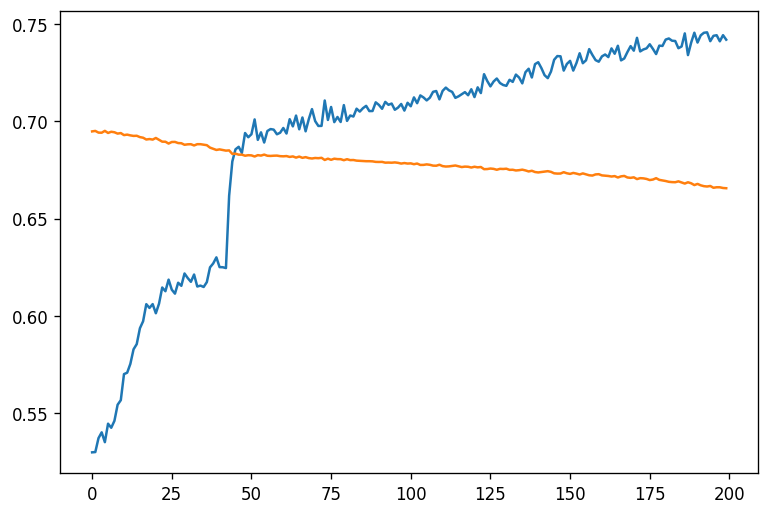

In [22]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(fourier_values)
plt.plot(bce_values)

In [23]:
torch.save(model.state_dict(), os.path.join(os.getenv("HOME"), "higgs", "model_fourier.pth"))

In [24]:
model_weights = torch.load(os.path.join(os.getenv("HOME"), "higgs", "model_fourier.pth"), weights_only = True)

In [25]:
model.load_state_dict(model_weights)

<All keys matched successfully>

In [26]:
test_ds = HiggsDataset(test_df)

In [27]:
predictions = []
eval_model = model.eval().cpu()
test_dl = torch.utils.data.DataLoader(dataset = test_ds, batch_size = 250)
for x, _ in tqdm(test_dl):
    xs = x.detach().cpu()
    ys = eval_model.forward(xs).detach().cpu()
    predictions.append(ys)
predictions = torch.vstack(predictions).detach().cpu()

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 226.14it/s]


In [28]:
predictions[:10, :]

tensor([[0.4616, 0.5242],
        [0.4900, 0.4968],
        [0.5341, 0.4657],
        [0.5467, 0.4456],
        [0.4885, 0.4985],
        [0.4721, 0.5142],
        [0.5592, 0.4381],
        [0.5259, 0.4635],
        [0.5010, 0.4853],
        [0.4249, 0.5651]])

In [29]:
import sklearn.metrics
import sklearn.preprocessing

In [30]:
import numpy as np

In [31]:
test_onehot = np.zeros(shape = (len(test_df), 2), dtype = np.float32)
test_onehot[~~test_df["label"].to_numpy(), 1] = 1
test_onehot[~test_df["label"].to_numpy(), 0] = 1

In [32]:
predictions_np = predictions.numpy()

In [33]:
for i in range(target_count):
    print(i, sklearn.metrics.roc_auc_score(test_onehot[:, i], predictions_np[:, i]))

0 0.745084568313588
1 0.7444984096553057


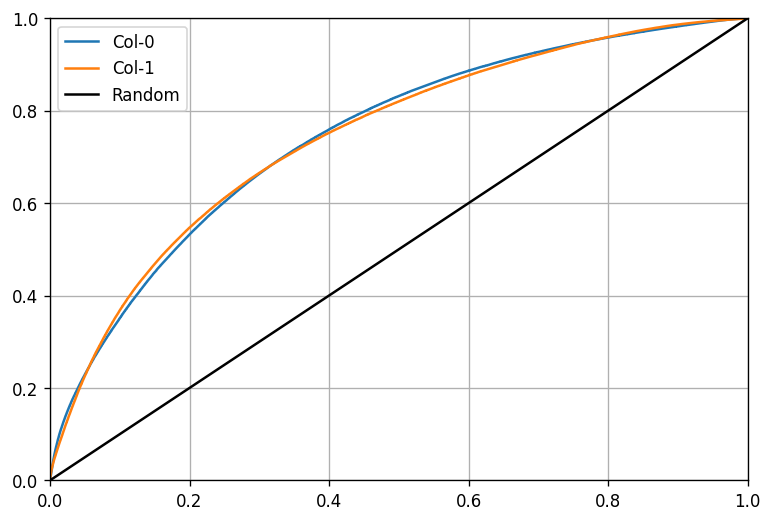

In [34]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(target_count):
    fpr, tpr, thr = sklearn.metrics.roc_curve(test_onehot[:, i], predictions_np[:, i])
    plt.plot(fpr, tpr, label = f"Col-{i}")
plt.plot([0.0, 1.0], [0.0, 1.0], label = "Random", color = "k")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

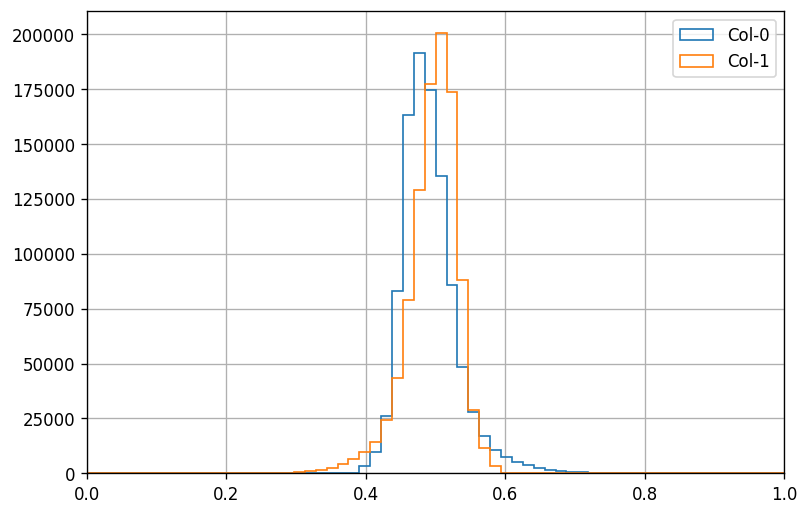

In [35]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(target_count):
    plt.hist(predictions_np[:, i], bins = 64, range = (0, 1), histtype = "step", label = f"Col-{i}")
plt.legend()
plt.xlim(0, 1)
plt.grid()

In [36]:
xs = torch.arange(0.0, 1.0, 1e-6, dtype = torch.float32)

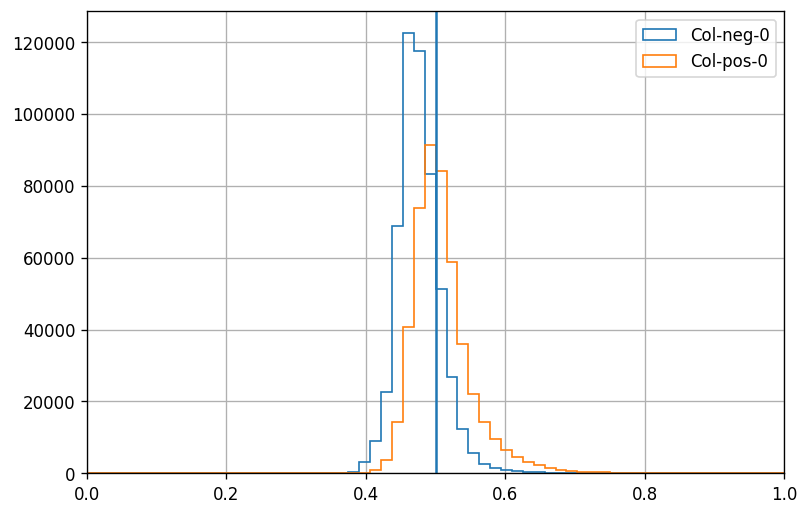

In [37]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(1):
    plt.hist(predictions_np[:, i][test_onehot[:, i] == 0], bins = 64, range = (0, 1), histtype = "step", label = f"Col-neg-{i}")
    plt.hist(predictions_np[:, i][test_onehot[:, i] == 1], bins = 64, range = (0, 1), histtype = "step", label = f"Col-pos-{i}")
plt.axvline(x = 0.5)
plt.legend()
plt.xlim(0, 1)
plt.grid()

In [38]:
from fourier.compute_fourier import compute_fourier_batched

In [39]:
scores_fourier = list()
n_harmonics = 128
predictions_scaled = predictions.detach()

for i in range(target_count):
    fourier = compute_fourier_batched(predictions_scaled[:, i], n_harmonics = n_harmonics)
    scores_fourier.append(fourier)

In [40]:
cdf_fourier = [integrate(fourier) for fourier in scores_fourier]
cdf_fourier = [normalize_by_samples(fourier) for fourier in cdf_fourier]

In [41]:
predictions_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(scores_fourier[i])
    predictions_eval.append(evaluate_fourier(xs, fourier))

predictions_eval = torch.stack(predictions_eval)

In [42]:
from fourier.evaluate_fourier import evaluate_fourier_batched

In [43]:
cdf_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(cdf_fourier[i])
    cdf_eval.append(evaluate_fourier_batched(xs, fourier))

cdf_eval = torch.stack(cdf_eval).numpy()
cdf_eval = (cdf_eval + 0.25) / 1.75

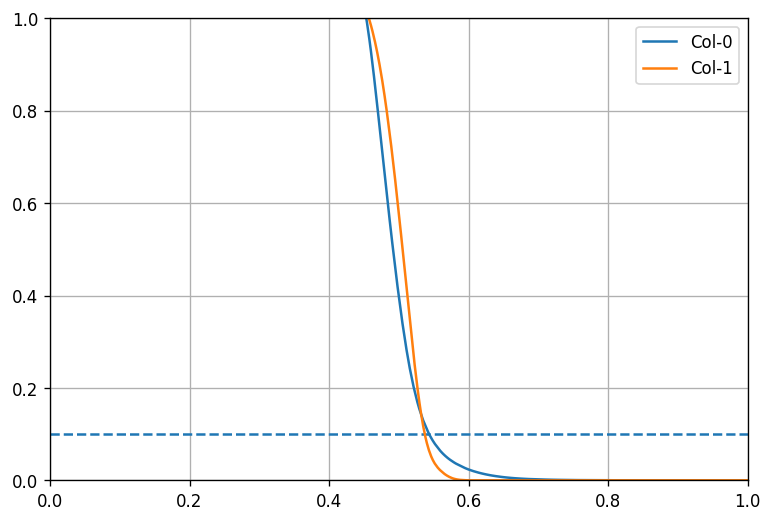

In [44]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.axhline(y = 0.1, linestyle = "--")
for i in range(target_count):
    plt.plot(xs.numpy(), 1 - cdf_eval[i, :], label = f"Col-{i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [45]:
def others_cdf(i):
    result = int(0)
    for j in range(target_count):
        if i != j:
            result = result + cdf_fourier[j]
    return normalize_by_samples(result)

In [46]:
other_cdfs = [others_cdf(i) for i in range(target_count)]

In [47]:
others_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(other_cdfs[i])
    others_eval.append(evaluate_fourier(xs, fourier))

others_eval = torch.stack(others_eval).numpy()
others_eval = (others_eval + 0.25) / 1.75

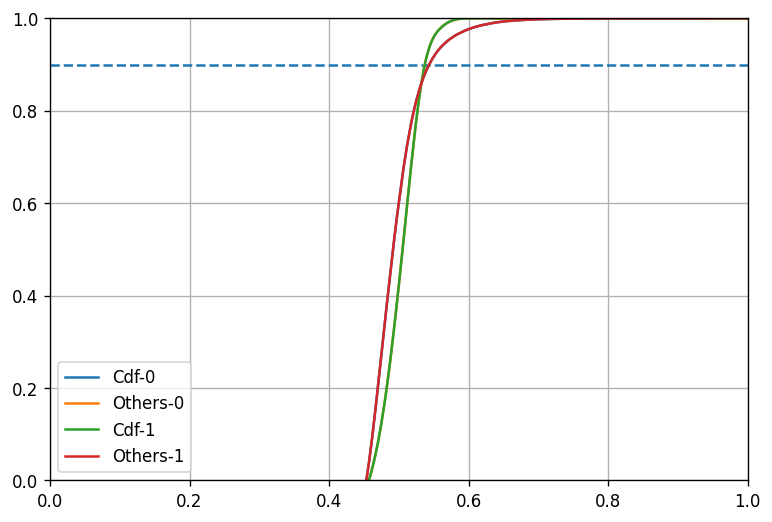

In [48]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.axhline(y = 0.9, linestyle = "--")
for i in range(target_count):
    plt.plot(xs.numpy(), cdf_eval[i, :], label = f"Cdf-{i}")
    plt.plot(xs.numpy(), others_eval[i, :], label = f"Others-{i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [49]:
c0_ind = torch.asarray(test_onehot[:, 0]).to(torch.bool)
c0_pos, c0_neg = torch.nonzero(c0_ind), torch.nonzero(~c0_ind)
c0_pos, c0_neg = c0_pos.squeeze(-1), c0_neg.squeeze(-1)

In [50]:
c0_predictions = predictions[:, 0].detach().squeeze(-1)
c0_pos_scores, c0_neg_scores = c0_predictions[c0_pos], c0_predictions[c0_neg]

In [51]:
c0_pos_fourier, c0_neg_fourier = compute_fourier(c0_pos_scores, n_harmonics), compute_fourier(c0_neg_scores, n_harmonics)
c0_pos_fourier, c0_neg_fourier = normalize_by_samples(c0_pos_fourier), normalize_by_samples(c0_neg_fourier)

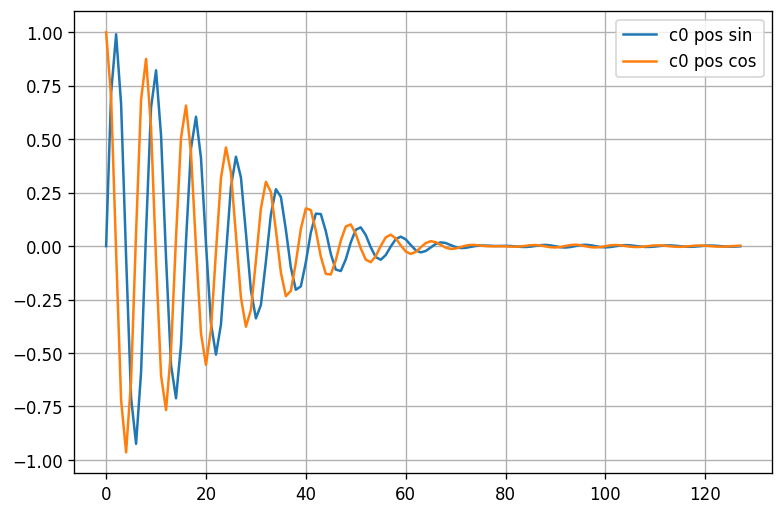

In [52]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_pos_fourier.sin.numpy(), label = "c0 pos sin")
plt.plot(c0_pos_fourier.cos.numpy(), label = "c0 pos cos")
plt.legend()
plt.grid()

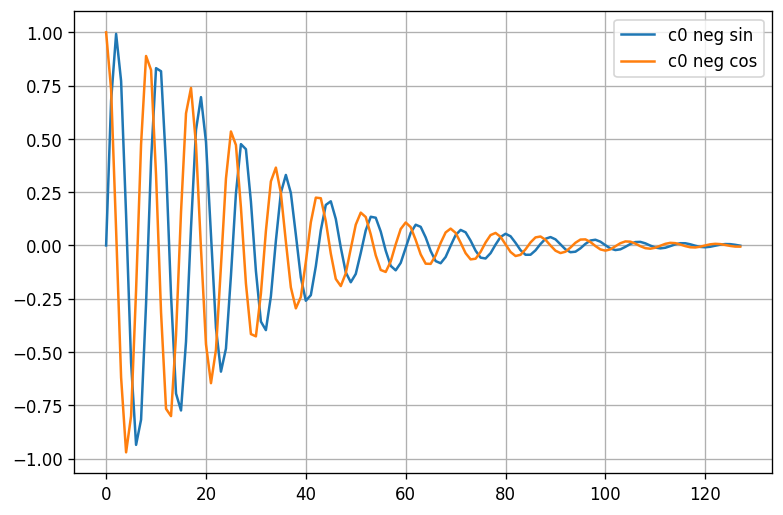

In [53]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_fourier.sin.numpy(), label = "c0 neg sin")
plt.plot(c0_neg_fourier.cos.numpy(), label = "c0 neg cos")
plt.legend()
plt.grid()

In [54]:
c0_pos_eval, c0_neg_eval = evaluate_fourier_batched(xs, c0_pos_fourier), evaluate_fourier_batched(xs, c0_neg_fourier)

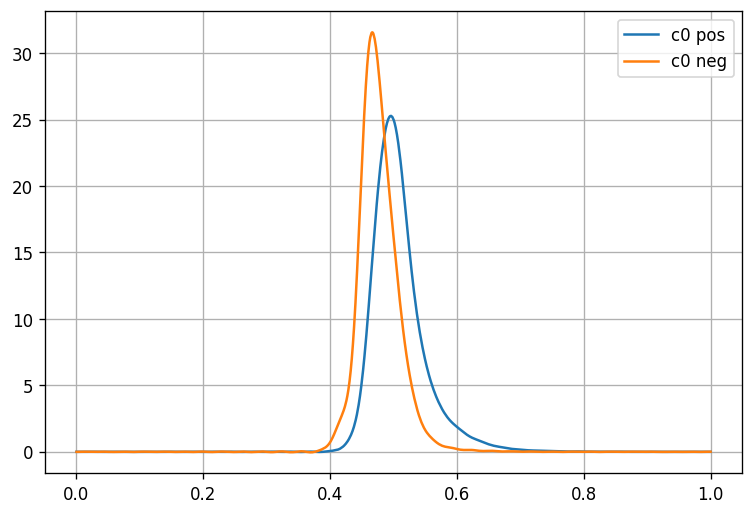

In [55]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_eval.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_eval.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

In [56]:
c0_pos_cdf, c0_neg_cdf = integrate(c0_pos_fourier), integrate(c0_neg_fourier)
c0_pos_cdf, c0_neg_cdf = normalize_by_samples(c0_pos_cdf), normalize_by_samples(c0_neg_cdf)

In [57]:
c0_pos_cdf_eval, c0_neg_cdf_eval = evaluate_fourier(xs, c0_pos_cdf), evaluate_fourier(xs, c0_neg_cdf)

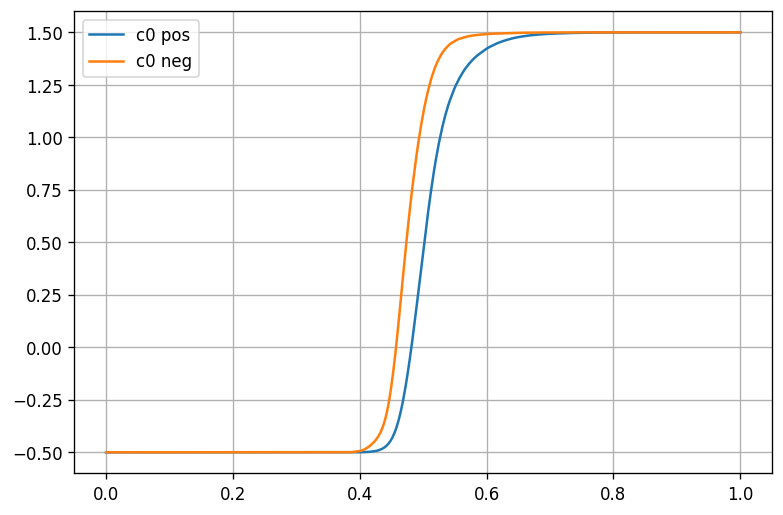

In [58]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_cdf_eval.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_cdf_eval.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

In [59]:
c0_pos_norm = 1 - (c0_pos_cdf_eval + 0.5) * 0.5
c0_neg_norm = 1 - (c0_neg_cdf_eval + 0.5) * 0.5

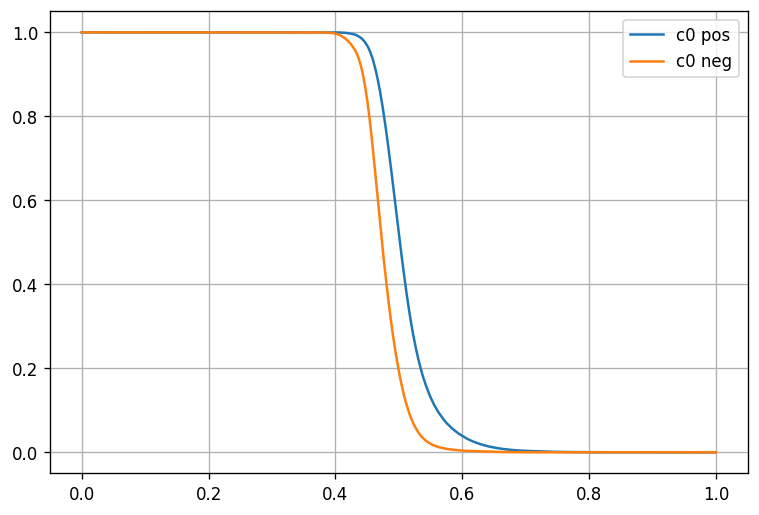

In [60]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_norm.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_norm.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

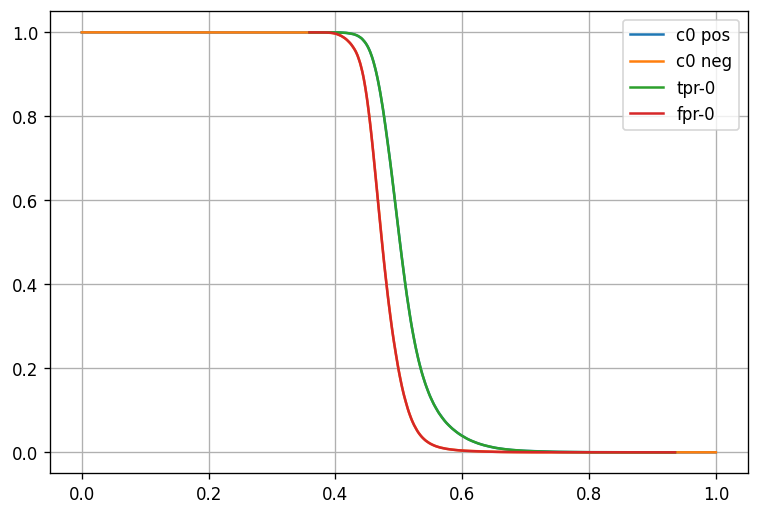

In [61]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_norm.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_norm.numpy(), label = "c0 neg")

fpr, tpr, thr = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(thr, tpr, label = f"tpr-0")
plt.plot(thr, fpr, label = f"fpr-0")

plt.legend()
plt.grid()

In [62]:
c0_neg_add = np.hstack([[1], c0_neg_norm.numpy(), [0]])
c0_pos_add = np.hstack([[1], c0_pos_norm.numpy(), [0]])

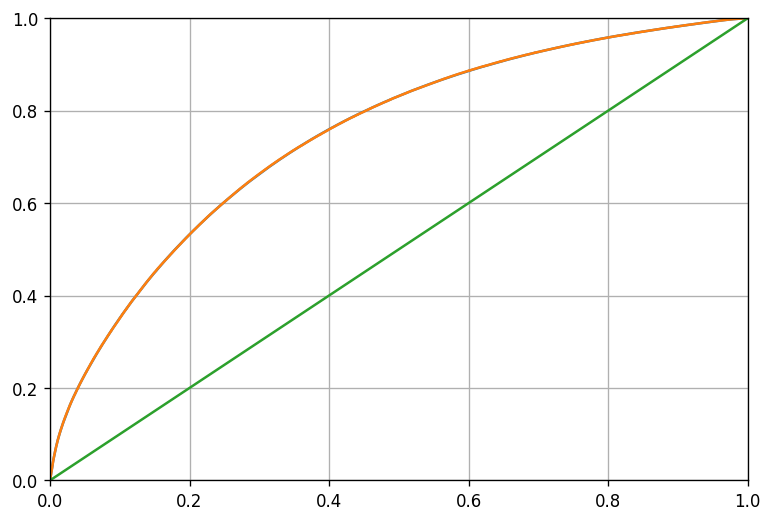

In [63]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_add, c0_pos_add)
fpr, tpr, _ = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(fpr, tpr, label = f"tpr-0")
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

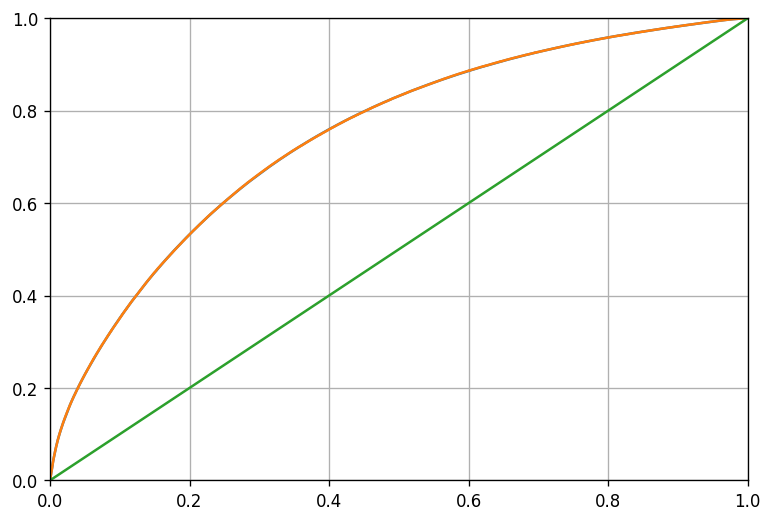

In [64]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_add, c0_pos_add)
fpr, tpr, _ = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(fpr, tpr, label = f"tpr-0")
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [65]:
renorm_fpr_diff = -np.diff(c0_neg_add)

roc_auc_renorm = np.sum(c0_pos_add[:-1] * renorm_fpr_diff)
roc_auc_renorm.item()

0.7450886867961302

In [66]:
renorm_tpr_diff = np.diff(c0_pos_add)

roc_auc_renorm = np.sum(c0_neg_add[:-1] * renorm_tpr_diff)
1 + roc_auc_renorm.item()

0.7450812174898331

In [68]:
from fourier.roc_auc_loss import ColumnRocAuc

In [69]:
cra = ColumnRocAuc()

In [81]:
cra(predictions_scaled[:, 0], torch.asarray(test_onehot[:, 0]))

tensor(0.7451)

In [82]:
cra(predictions_scaled[:, 1], torch.asarray(test_onehot[:, 1]))

tensor(0.7445)

In [83]:
from fourier.roc_auc_loss import RocAuc

In [84]:
ra = RocAuc(statistic = "max")

In [85]:
ra(predictions_scaled, torch.asarray(test_onehot))

tensor(0.7451)

In [86]:
ra = RocAuc(statistic = "min")

In [87]:
ra(predictions_scaled, torch.asarray(test_onehot))

tensor(0.7445)